# Exploration
Complete EDA.ipynb first!

This notebook is a starting point for your own exploration of the data and should build upon your work and knowledge gained from EDA.ipynb. As a reminder, the goal is to identify the primary source(s) of failures and downtimes and, if possible, to assess the certainty of those conclusions.

Some questions you could explore are:
- Which Machines are responsible for 80% of overall Total Failures? Of overall Total Failure Downtime?
- Are there significant differences in the performances of Machines, Shifts, or Operators?
- If every minute of Cable Failure Downtime represents eight dollars of lost revenue and Other Failure Downtime represents five dollars then which Machines or Operators are responsible for the most lost revenue? 

In [1]:
# import libraries
import pandas as pd
import numpy as np

import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# a simple theme that's better than the default
sns.set_theme(
    context='notebook',
    style='darkgrid', 
    palette='husl',
    rc={"figure.figsize":(24, 8)}
)

# set pandas display option
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# load and combine datasets
def load_combine(copper_file: str, operator_file: str)->pd.DataFrame:
    """
    Load, process & combine the contents of the copper_file and operator_file.
    
    Params:
    copper_file - str; the path to the copper file.
    operator_file - str; the path to the operator file.
    
    Returns:
    combined_df - pd.DataFrame; the extracted and combined content of the 
        two files. There should be 10 columns available after combining the
        two files and dropping any unecessary columns.   
    """
    
    assert isinstance(operator_file, str), 'operator_file path is not of type str.'
    assert isinstance(copper_file, str), 'copper_file path is not of type str.'
    
    # Store references in lists
    combination = ['Machine', 'Shift', 'Operator', 'Date']
    operator_columns=['Operator Number','First Name','Last Initial']
    
    # load and remove duplicates on copper_file
    copper_df = pd.read_excel(copper_file, index_col = 0)

    copper_df = copper_df.drop_duplicates(subset = combination).reset_index(drop=True)
    
    print('There are {} rows in copper_file after dropping duplicates'.format(copper_df.shape[0]))
    print('')
    
    # load and pre-process operator_file
    operator = pd.read_csv(operator_file,
                           sep=r',', 
                           header = None,
                           names = operator_columns,
                           delim_whitespace=True)
    
    operator['Last Initial'] = operator['Last Initial'].astype(str).str[0]
    
    # create an empty operator_df to fill with contents of operator_file
    operator_df = pd.DataFrame(operator)
    
    # merge copper_df with operator_df using on 'Operator' = 'Operator Number'
    combined_df = copper_df.merge(operator_df, 
                                  how='left', 
                                  left_on='Operator', 
                                  right_on='Operator Number')

    # drop duplicated column & inspect the new combined table
    combined_df.drop('Operator', axis=1, inplace=True)
    
    return combined_df

In [3]:
# function for feature engineering
def feature_engineer(df: pd.DataFrame)->pd.DataFrame:
    """
    Engineer new features for the combined_df data frame.
    
    Params:
    df - DataFrame; the data frame used to add new features.
    
    Returns:
    combined_df - pd.DataFrame; a new data frame with newly created features.
        These features include 'Operator Name', Day of Week', 'Total Failure', 'Total Downtime', 
        and 'Total Failure Downtime'. A total of 13 features will be returned.
    """
    
    assert isinstance(df, pd.DataFrame), 'df is not a DataFrame.'
    
    cols = ['First Name', 'Last Initial']
    
    # create new features   
    df['Operator Name'] = df['First Name'] + '_' + df['Last Initial']
    df['Day of Week'] = df['Date'].dt.day_name()
    df['Total Failures'] = df['Cable Failures'] + df['Other Failures']
    df['Total Downtime'] = df['Cable Failure Downtime'] + df['Other Failure Downtime']
    df['Total Downtime hr'] = round(df['Total Downtime']/60, 2)
    
    # create an empty combined_df and fill with content with df
    combined_df = pd.DataFrame(df)
    
    combined_df.drop(cols, axis=1, inplace=True)
    
    return combined_df

In [4]:
# get the paths of the 2 files
COPPER_FILE = 'data/copper_production_v1.xlsx'
OPERATOR_FILE = 'data/operator_names.txt'

abs_path_copper = os.path.abspath(COPPER_FILE)
abs_path_operator = os.path.abspath(OPERATOR_FILE)

# combine 2 files using pre-defined function and print out the first 5 rows
df = load_combine(abs_path_copper, abs_path_operator)
df.head()

There are 145 rows in copper_file after dropping duplicates



,Machine,Shift,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Number,First Name,Last Initial
0,6,A,2020-11-15,0,0,1,60,12,Tad,S
1,6,B,2020-11-10,0,0,0,0,12,Tad,S
2,2,A,2020-11-06,1,10,3,150,2,Hugh,R
3,8,B,2020-11-16,3,175,0,0,13,Marcel,C
4,7,B,2020-11-21,1,55,0,0,14,Fritz,M


In [5]:
# feature engineer df dataframe using pre-defined function and print out first 5 rows
combined_df = feature_engineer(df)

combined_df.head()

,Machine,Shift,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Number,Operator Name,Day of Week,Total Failures,Total Downtime,Total Downtime hr
0,6,A,2020-11-15,0,0,1,60,12,Tad_S,Sunday,1,60,1.00
1,6,B,2020-11-10,0,0,0,0,12,Tad_S,Tuesday,0,0,0.00
2,2,A,2020-11-06,1,10,3,150,2,Hugh_R,Friday,4,160,2.67
3,8,B,2020-11-16,3,175,0,0,13,Marcel_C,Monday,3,175,2.92
4,7,B,2020-11-21,1,55,0,0,14,Fritz_M,Saturday,1,55,0.92


In [6]:
# inspect column datatype and check columns with missing values
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Machine                 145 non-null    int64         
 1   Shift                   145 non-null    object        
 2   Date                    145 non-null    datetime64[ns]
 3   Cable Failures          145 non-null    int64         
 4   Cable Failure Downtime  145 non-null    int64         
 5   Other Failures          145 non-null    int64         
 6   Other Failure Downtime  145 non-null    int64         
 7   Operator Number         145 non-null    int64         
 8   Operator Name           145 non-null    object        
 9   Day of Week             145 non-null    object        
 10  Total Failures          145 non-null    int64         
 11  Total Downtime          145 non-null    int64         
 12  Total Downtime hr       145 non-null    float64   

In [7]:
# combined_df simple statistics on numeric variables
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Machine,145.0,5.910345,4.347600,1.0,2.0,5.0,8.0,17.0
Cable Failures,145.0,1.413793,1.331176,0.0,0.0,1.0,2.0,6.0
Cable Failure Downtime,145.0,51.827586,57.251315,0.0,0.0,35.0,70.0,295.0
Other Failures,145.0,0.537931,0.979092,0.0,0.0,0.0,1.0,9.0
Other Failure Downtime,145.0,47.586207,107.676056,0.0,0.0,0.0,45.0,690.0
Operator Number,145.0,12.993103,8.765856,1.0,6.0,12.0,19.0,32.0
Total Failures,145.0,1.951724,1.420735,0.0,1.0,1.0,2.0,9.0
Total Downtime,145.0,99.413793,113.344827,0.0,30.0,60.0,120.0,690.0
Total Downtime hr,145.0,1.657103,1.889259,0.0,0.5,1.0,2.0,11.5


In [8]:
# inspect categorical variables
columns = ['Shift', 'Operator Name', 'Day of Week']

for col in combined_df[columns].columns:
    print(np.sort(combined_df[col].unique()))
    print('')

['A' 'B']

['Archy_B' 'Bennett_W' 'Byron_B' 'Christopher_G' 'Connie_M' 'Courtney_H'
 'David_S' 'Delmer_K' 'Diego_S' 'Dudley_S' 'Elliott_V' 'Eugene_W'
 'Floyd_G' 'Francisco_L' 'Fritz_M' 'Gonzalo_J' 'Harlan_B' 'Hess_H'
 'Hugh_R' 'Joesph_W' 'Jose_G' 'Lilly_Z' 'Lindsey_F' 'Marcel_C' 'Maurice_O'
 'Nichole_H' 'Norris_H' 'Rodney_G' 'Roland_M' 'Tad_S' 'Vince_F'
 'Woodrow_S']

['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']



In [9]:
# inspect date variable
print(np.sort(combined_df['Date'].unique()))

# get the total number of unique dates
print('There are {} unique dates in the dataset'.format(combined_df['Date'].nunique()))

['2020-11-06T00:00:00.000000000' '2020-11-07T00:00:00.000000000'
 '2020-11-08T00:00:00.000000000' '2020-11-09T00:00:00.000000000'
 '2020-11-10T00:00:00.000000000' '2020-11-12T00:00:00.000000000'
 '2020-11-13T00:00:00.000000000' '2020-11-14T00:00:00.000000000'
 '2020-11-15T00:00:00.000000000' '2020-11-16T00:00:00.000000000'
 '2020-11-17T00:00:00.000000000' '2020-11-18T00:00:00.000000000'
 '2020-11-19T00:00:00.000000000' '2020-11-20T00:00:00.000000000'
 '2020-11-21T00:00:00.000000000' '2020-11-22T00:00:00.000000000']
There are 16 unique dates in the dataset


Looking from the above dates, we can see that 2020-11-11 was missing from the date range. We will perform imputation later after exploring the data

## Machine variable vs total failures/downtime

#### 1. What machine were used the most out of all machines?

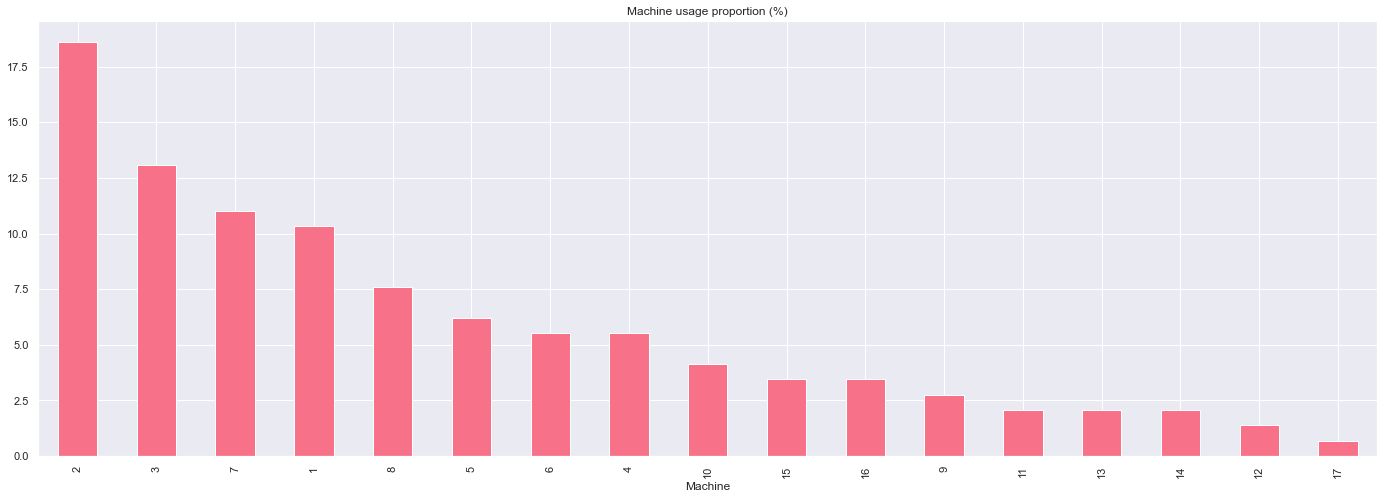

In [10]:
# create machine_proportion and draw a barchart
machine_proportion= combined_df.groupby('Machine')['Machine'].count()/len(combined_df)*100

machine_proportion.sort_values(ascending=False).plot(kind='bar',
                                                     title = 'Machine usage proportion (%)')

According to the above bar chart, machine number 2 was used the most out of all other machines (18.6% of total machine usage)

#### 2. What machine are responsible for the most failures and downtime?

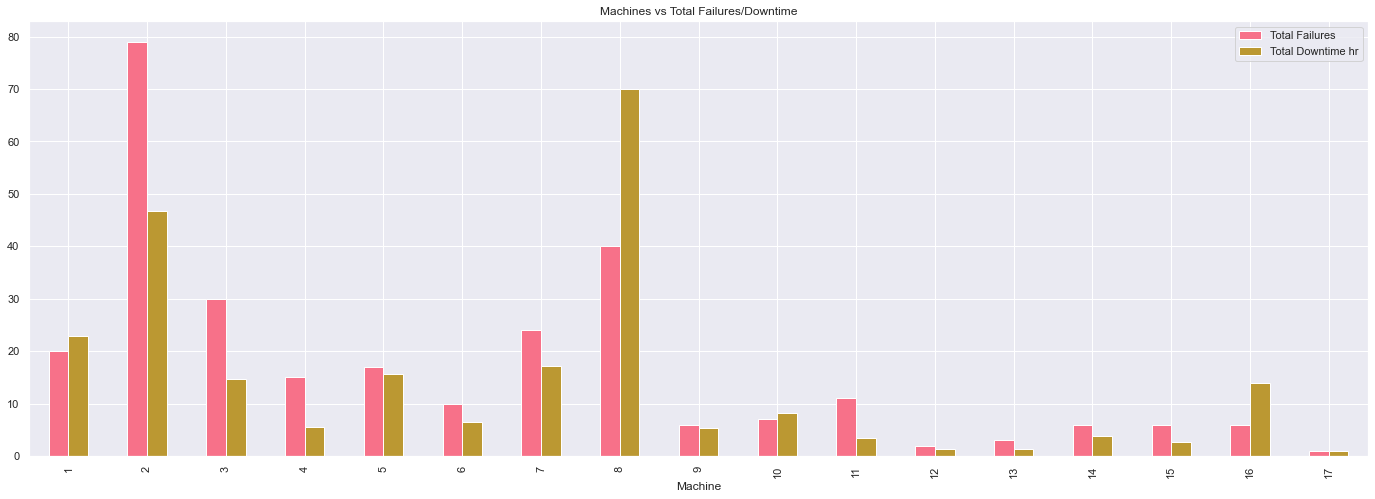

In [11]:
# create new dataframe that capture the relationship between machine and total failures/downtime
machine_failure_downtime = combined_df.groupby('Machine')['Total Failures', 'Total Downtime hr'].sum()

machine_failure_downtime.plot(kind='bar', 
                              title = 'Machines vs Total Failures/Downtime')

In [12]:
# proportion of total failures per each machine
machine_failure = combined_df.groupby('Machine')['Total Failures'].sum()/combined_df['Total Failures'].sum()*100
machine_failure.sort_values(ascending = False).head()

Machine
2    27.915194
8    14.134276
3    10.600707
7     8.480565
1     7.067138
Name: Total Failures, dtype: float64

In [13]:
# percent of downtime(hr)/total downtime(hr) per each machine
machine_downtime = combined_df.groupby('Machine')['Total Downtime hr'].sum()/combined_df['Total Downtime hr'].sum()*100
machine_downtime.sort_values(ascending = False).head()

Machine
8    29.103546
2    19.423173
1     9.505577
7     7.149992
5     6.513235
Name: Total Downtime hr, dtype: float64

Even though machine 2 was ultilized the most and contributed to the highest number of failures (about 28% of total failures), machine 8 caused the highest number of downtime (70 hrs or 29% of total downtime hrs). This means machines associated with the highest number of failures don't necessarily caused the longest downtime.

#### 3. What machine should be focused on?

In [14]:
# create avg downtime/failure metric for each machine
machine_downtime_per_failure = combined_df[['Machine', 'Total Failures', 'Total Downtime']]

machine_downtime_per_failure = machine_downtime_per_failure.groupby('Machine')[['Total Failures','Total Downtime']].sum()

machine_downtime_per_failure['Avg Downtime(min)/Failure'] = machine_downtime_per_failure['Total Downtime']/ machine_downtime_per_failure['Total Failures']

machine_downtime_per_failure.sort_values(by = 'Avg Downtime(min)/Failure', ascending = False)

,Total Failures,Total Downtime,Avg Downtime(min)/Failure
Machine,,,
16,6,835,139.166667
8,40,4195,104.875000
10,7,495,70.714286
1,20,1370,68.500000
17,1,60,60.000000
5,17,940,55.294118
9,6,320,53.333333
7,24,1030,42.916667
12,2,85,42.500000


This is interesting! 

From an utilization perspective, the manufacturer would probably want to fix/maintain/service machine 2 and machine 3 the most because they are the highest ultilized machines of all in the shop.

However, when it comes to performance, machine 16 and machine 8 need to be focused on the most because they tend to have a longer downtime whenever a failure happens.

## Shift variable vs total failures/downtime

#### 1. What shift is associated with the most amout of total failures/downtime?

In [15]:
# inspect shift proportion
shift_proportion= combined_df.groupby('Shift')['Shift'].count()/len(combined_df)*100

shift_proportion

Shift
A    51.034483
B    48.965517
Name: Shift, dtype: float64

The number of shifts were well distributed between shift A and shift B with shift A accounted for 51% of the total number of shifts, and shift B accounted for 49%, respectively.

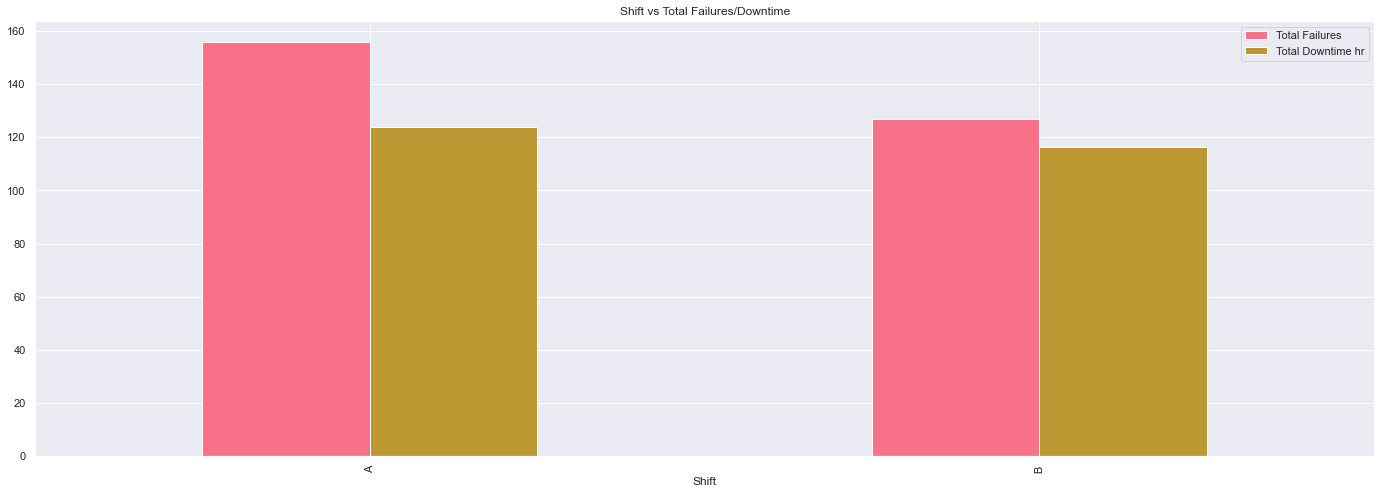

In [16]:
# plot the relationship between shift and total failures/downtime
combined_df.groupby('Shift')['Total Failures', 'Total Downtime hr'].sum().plot(kind='bar',
                                                                               title = 'Shift vs Total Failures/Downtime')

According to the barchart above, even though shift A and shift B accounted for similar amount of total downtime (around 120 total hrs), the number of failures that happened on Shift A was remarkably higher than the number of failures that happened on Shift B. 

Could this be because shift A ultilizes more machines that have a higher number of failures but shorter downtimes?

#### 2. How different shifts ultilize different machines?

In [17]:
# create shift_machine df that contains shift and machine ultilization info
shift_machine = combined_df[['Shift', 'Machine']]

# inspect what machines were used in each shift
df = shift_machine.groupby(['Shift', 'Machine'])['Machine'].count()
print(df)

Shift  Machine
A      1           9
       2          13
       3           9
       4           3
       5           6
       6           6
       7           6
       8           5
       9           4
       10          3
       11          1
       12          2
       13          1
       14          1
       15          2
       16          2
       17          1
B      1           6
       2          14
       3          10
       4           5
       5           3
       6           2
       7          10
       8           6
       10          3
       11          2
       13          2
       14          2
       15          3
       16          3
Name: Machine, dtype: int64


In [18]:
# calculate machine ultilization between shift A and shift B
shift_machine[shift_machine['Shift'] == 'A'].groupby(['Machine'])['Machine'].count() - shift_machine[shift_machine['Shift'] == 'B'].groupby(['Machine'])['Machine'].count()

Machine
1     3.0
2    -1.0
3    -1.0
4    -2.0
5     3.0
6     4.0
7    -4.0
8    -1.0
9     NaN
10    0.0
11   -1.0
12    NaN
13   -1.0
14   -1.0
15   -1.0
16   -1.0
17    NaN
Name: Machine, dtype: float64

Shift A ultilized machine 1, 5, 6, 9, 12, 17 more often than shift B. Notice in the previous section, machine 1, 5, and 6 are ones that have higher number of total failures.

Shift B, on the other hand, ultilized machine 4, 7, 11, 13 and 15 more often than shift A. These are machines that have a shorter average downtime per failure.

## Operator variable vs total failures/downtime

#### 1. What operators were associated with the highest number of failure/downtime?

In [42]:
# Which operators worked the highest amount of shifts?
combined_df.groupby('Operator Name')['Shift'].count().sort_values(ascending = False).head()

Operator Name
Fritz_M       13
Courtney_H    11
Byron_B        9
Rodney_G       8
Elliott_V      8
Name: Shift, dtype: int64

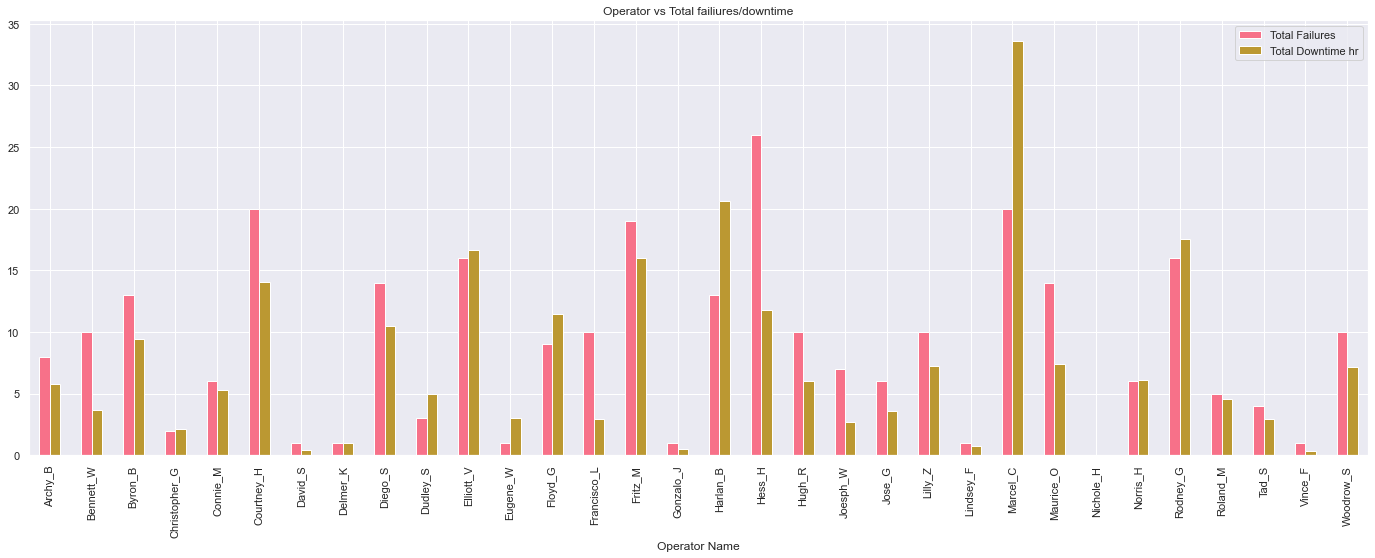

In [44]:
# plot barchart showing the number of total failures and downtime per each operator
combined_df.groupby('Operator Name')[['Total Failures', 'Total Downtime hr']].sum().plot(kind='bar',
                                                                                         title = 'Operator vs Total failiures/downtime')

According to the barchart above, even though Hess_H and Courtney_H contributed to the highest number of failures within the dataset, it is Marcel_C and Harlan_B that had the longest total downtime.

Let's take a closer look at the data!

#### 2. Do machines play a role in operator performance?

In [20]:
# let's take a look at operators with the highest number of failures
combined_df.groupby('Operator Name')[['Total Failures', 'Total Downtime']].sum().sort_values(by = 'Total Failures', ascending = False).head()

,Total Failures,Total Downtime
Operator Name,,
Hess_H,26,710
Courtney_H,20,845
Marcel_C,20,2015
Fritz_M,19,960
Rodney_G,16,1050


In [21]:
# operators with the highest number of downtime
combined_df.groupby('Operator Name')[['Total Failures', 'Total Downtime']].sum().sort_values(by = 'Total Downtime', ascending = False).head()

,Total Failures,Total Downtime
Operator Name,,
Marcel_C,20,2015
Harlan_B,13,1240
Rodney_G,16,1050
Elliott_V,16,1000
Fritz_M,19,960


In [22]:
# inspect only operators of interest
operators = ['Hess_H', 'Courtney_H', 'Marcel_C', 'Harlan_B']

operator_machine = combined_df[combined_df['Operator Name'].isin(operators)] 

operator_machine = operator_machine.groupby(['Operator Name', 'Machine'])[['Total Failures', 'Total Downtime']].sum()
operator_machine

Total Failures  Total Downtime
Operator Name Machine                                
Courtney_H    1                    11             560
              2                     3              70
              6                     6             215
Harlan_B      8                    13            1240
Hess_H        2                    26             710
Marcel_C      2                     4             210
              5                     3             170
              7                     2             100
              8                    11            1535

It looks like Hess_H only operated machine 2. If you remember from the analysis earlier in the machine section, machine 2 was the highest ultilized machine and had the highest number of failures. However, it had a smaller downtime/failure rate. That explains why even though Hess_H had the highest number of failures across the time series, the total amount of downtime during his/her shifts was not as high as others.

Harlan_B was assigned to machine 8, which not only failed more often, but also had a higher rate of downtime/failure. 

Courtney_H and Marcel_C both operated multiple machines. Courtney_H's high failure rate was mainly due to machine 1 and machine 6. These two machines, however, had shorter average downtime per each failure, similar to Hess_H situation. 

Marcel_C operated on 4 different machines, but used machine 8 the most out of others. As explained above, machine 8 had one of the biggest downtime/failure rates.

#### 3. If every minute of Cable Failure Downtime represents eight dollars of lost revenue and Other Failure Downtime represents five dollars then which Machines or Operators are responsible for the most lost revenue?

In [23]:
# create revenue by machine df and calculate lost revenue
rev_by_machine = combined_df[['Machine', 'Cable Failure Downtime', 'Other Failure Downtime']]

rev_by_machine['Lost Revenue'] = (combined_df['Cable Failure Downtime'] * 8) + (combined_df['Other Failure Downtime'] * 5)

rev_by_machine.head()

,Machine,Cable Failure Downtime,Other Failure Downtime,Lost Revenue
0,6,0,60,300
1,6,0,0,0
2,2,10,150,830
3,8,175,0,1400
4,7,55,0,440


In [24]:
# machines associated with the most amount of lost revenue 
rev_by_machine.groupby('Machine')['Lost Revenue'].sum().sort_values(ascending = False).head(2)

Machine
8    25250
2    18665
Name: Lost Revenue, dtype: int64

In [25]:
# create revenue by operator df and calculate lost revenue
rev_by_operator = combined_df[['Operator Name', 'Cable Failure Downtime', 'Other Failure Downtime']]

rev_by_operator['Lost Revenue'] = (combined_df['Cable Failure Downtime'] * 8) + (combined_df['Other Failure Downtime'] * 5)

rev_by_operator.head()

,Operator Name,Cable Failure Downtime,Other Failure Downtime,Lost Revenue
0,Tad_S,0,60,300
1,Tad_S,0,0,0
2,Hugh_R,10,150,830
3,Marcel_C,175,0,1400
4,Fritz_M,55,0,440


In [26]:
# operator associated with the most amount of lost revenue 
rev_by_operator.groupby('Operator Name')['Lost Revenue'].sum().sort_values(ascending = False).head(2)

Operator Name
Marcel_C    12490
Harlan_B     7535
Name: Lost Revenue, dtype: int64

## Variable correlation

In [27]:
combined_df.head()

,Machine,Shift,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Number,Operator Name,Day of Week,Total Failures,Total Downtime,Total Downtime hr
0,6,A,2020-11-15,0,0,1,60,12,Tad_S,Sunday,1,60,1.00
1,6,B,2020-11-10,0,0,0,0,12,Tad_S,Tuesday,0,0,0.00
2,2,A,2020-11-06,1,10,3,150,2,Hugh_R,Friday,4,160,2.67
3,8,B,2020-11-16,3,175,0,0,13,Marcel_C,Monday,3,175,2.92
4,7,B,2020-11-21,1,55,0,0,14,Fritz_M,Saturday,1,55,0.92


In [28]:
# we will inspect correlation between machine, shift, operator, total failures and total downtime variables
# before doing so, we'll have to encode categorical variables

shift_mapping = {k: i for i, k in enumerate(combined_df['Shift'].unique(), 0)}
print(shift_mapping)

# create a copy oc combined_df and save it to corr_df
corr_df = combined_df.copy()

# map new values to shift
corr_df['Shift'] = combined_df['Shift'].map(shift_mapping)

print(corr_df['Shift'].unique())

{'A': 0, 'B': 1}
[0 1]


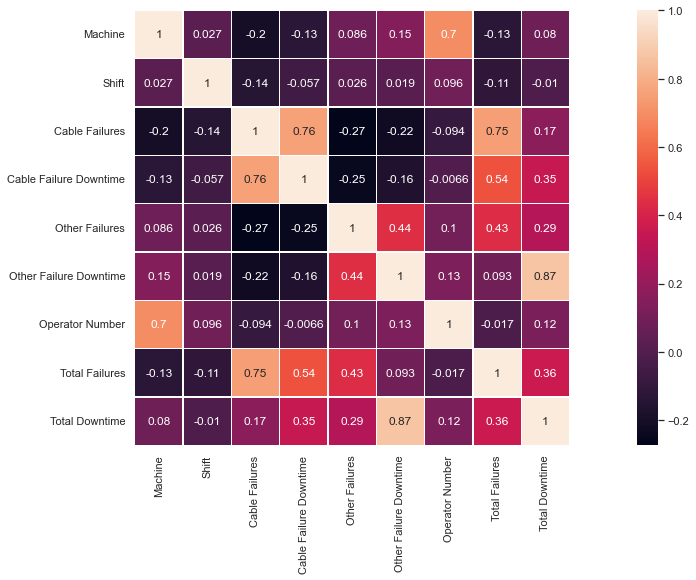

In [29]:
# calculate correlation for variables of interest
cols = ['Machine', 'Shift', 'Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime', 'Operator Number', 'Total Failures', 'Total Downtime']

corr = corr_df[cols].corr()

# plot correlation heatmap
sns.heatmap(corr, 
            annot=True, 
            linewidths=.5,
            square = True)

Okay, let's take a look at the above map representing the correlation coefficients between different variables in the dataset.

The correlation coefficient is a statistical measure of the strength of the relationship between the relative movements of two variables. A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive correlation. A correlation of 0.0 shows no linear relationship between the movement of the two variables.

We can see that Total Downtime and Other Failure Downtime are highly correlated. This is expected because Other Failure Downtime directly contributed to Total Downtime. But notice how Cable Failure Downtime has a much lower correlation coefficient than that of Other Failure Downtime even though it is also a part of the equation? Does that mean it's not as good of an indicator?

Same situation happened with Total Failures, Cable Failures and Other Failures variable

Another good one is Operator Number and Machine. It looks like these 2 variables also have a higher correlation coefficient. As we discovered earlier, some operators only operated on a single machine, or the same machines throughout the time that the data was recorded, whether because they were assigned to or in charge of only one machine or a set of machines, or because we don't have enough data from other weeks that they worked on other machines.

# End